## Guessing last day, ema, etc.

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import root_mean_squared_error

In [32]:
DIRECTORY = './data/'
calendar = pd.read_csv(DIRECTORY + 'calendar.csv', parse_dates=['date'])
train_validation = pd.read_csv(DIRECTORY + 'sales_train_validation.csv')
train_evaluation = pd.read_csv(DIRECTORY + 'sales_train_evaluation.csv')
prices = pd.read_csv(DIRECTORY + 'sell_prices.csv')

## pivoting

In [33]:
def downcast_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Downcast numeric columns in the DataFrame to more memory-efficient dtypes.
    Returns a copy of the DataFrame with downcasted dtypes.
    """
    df = df.copy()
    # Downcast integer columns
    int_cols = df.select_dtypes(include=['int', 'int32', 'int64']).columns
    for col in int_cols:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

In [34]:
train_validation = downcast_df(train_validation)
train_validation.dtypes
train_validation.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int16(1288), int8(625), object(6)
memory usage: 103.5 MB


In [5]:
useless = np.setdiff1d(train_validation.select_dtypes('object').columns, ['id'])
train_col = train_validation.drop(columns=useless).melt(id_vars=['id'])

In [6]:
train_col['id'], _ = train_col['id'].factorize()
train_col['variable'] = train_col['variable'].str.split('_').str[1].astype('int')

In [9]:
train_col = downcast_df(train_col)

In [38]:
train_col = train_col.rename(columns={'variable': 'day', 'value': 'sale'})

In [ ]:
train_col['last_sale'] = train_col.groupby('id')['sale'].shift(7).fillna(0)
train_col['last_sale'] = pd.to_numeric(train_col['last_sale'].astype(int), downcast='integer')

In [78]:
train_col['mean'] = train_col.groupby('id')['sale'].transform('mean')

In [89]:
moving_average = train_col.groupby('id')['sale'].ewm(alpha=0.005).mean().shift(1)

In [92]:
train_col['ema'] = moving_average.reset_index(level=0, drop=True)

In [106]:
train_col['mse'] = (train_col['sale'] - train_col['mean'])**2

In [114]:
mses = train_col.groupby(by='id')['mse'].sum().sort_values(ascending=False)
mses = mses / mses.sum() * 100

In [115]:
mses.head(30)

id
8412     5.112766
2314     1.451090
29755    1.315689
17559    1.266990
20608    1.002822
14510    0.919108
8442     0.901384
26850    0.579240
8603     0.555764
29983    0.554167
16274    0.538500
8957     0.519386
8863     0.517106
26624    0.503488
9127     0.494466
2344     0.487690
26578    0.486650
8640     0.448536
18055    0.413277
8909     0.382516
8929     0.364719
20549    0.341575
27028    0.338284
27326    0.328430
6324     0.327872
27163    0.315340
8604     0.300841
5363     0.278576
29899    0.278095
26686    0.275460
Name: mse, dtype: float64

In [94]:
from sklearn.metrics import root_mean_squared_error
root_mean_squared_error(train_col['sale'], train_col['ema'].fillna(0))

2.533691366360075

In [87]:
train_col['diff'] = abs(train_col['sale'] - train_col['ema'])

In [49]:
train_col.sort_values(by='diff', ascending=False).head(30)

,id,day,sale,last_sale,diff
15552906,3006,511,648,3,645
2971837,14307,98,634,0,634
15583396,3006,512,17,648,631
3002327,14307,99,9,634,625
10070112,8412,331,0,619,619
27670704,16274,908,626,15,611
34043114,16274,1117,1,606,605
26173774,13354,859,601,0,601
26204264,13354,860,0,601,601
30262354,16274,993,7,607,600


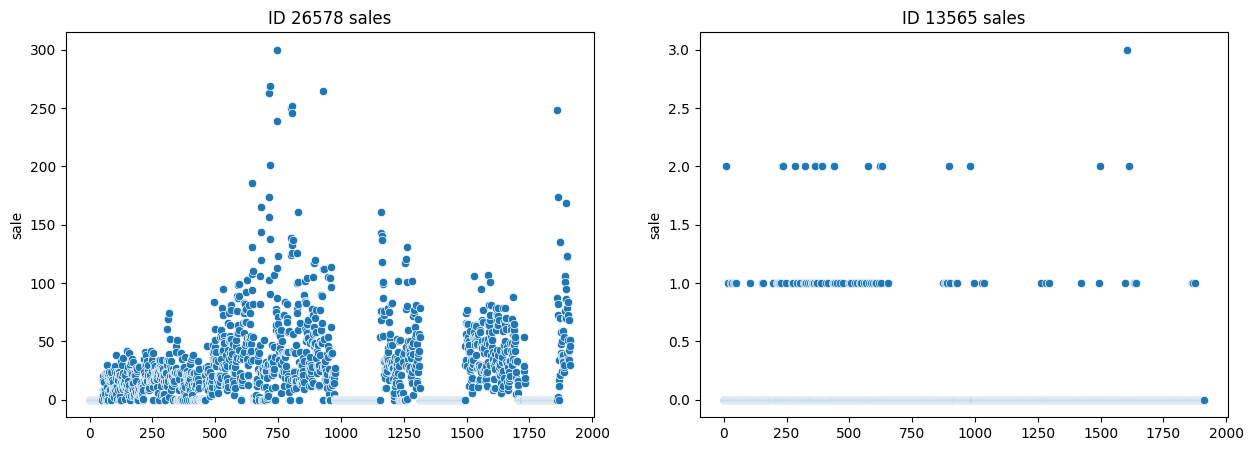

In [116]:
# Sample random ids
ids = random.choices(train_col['id'].unique(), k=10)
ids = [26578, 13565]

ncols = 2
nrows = (len(ids)+ncols-1)//ncols
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,nrows*5))
axs = axs.flatten()

for i, id in enumerate(ids):
    filtered = train_col[train_col['id'] == id]
    sns.scatterplot(x=np.arange(len(filtered)), y=filtered['sale'], ax=axs[i])
    axs[i].set_title(f'ID {id} sales')

In [100]:
# Look at these ids
train_col[train_col['id'] == 15630].tail(20)

,id,day,sale,last_sale,diff,mean,ema
57733200,15630,1894,0,0,1.010777,0.488238,1.015857
57763690,15630,1895,1,2,0.010723,0.488238,1.010777
57794180,15630,1896,0,2,1.005669,0.488238,1.010723
57824670,15630,1897,3,2,1.984358,0.488238,1.005669
57855160,15630,1898,1,1,0.015564,0.488238,1.015642
57885650,15630,1899,1,0,0.015486,0.488238,1.015564
57916140,15630,1900,0,1,1.010408,0.488238,1.015486
57946630,15630,1901,1,0,0.010356,0.488238,1.010408
57977120,15630,1902,1,1,0.010304,0.488238,1.010356
58007610,15630,1903,3,0,1.979747,0.488238,1.010304
